#📌 Extraction

In [2]:
# Librarys used here

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tabulate as tabulate
import folium
from pandas import json_normalize
from folium.plugins import HeatMap
import warnings
import dfply as dp

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

import json

#### Data dictionary 

- `customerID`: número de identificación único de cada cliente
- `Churn`: si el cliente dejó o no la empresa
- `gender`: género (masculino y femenino)
- `SeniorCitizen`: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
- `Partner`: si el cliente tiene o no una pareja
- `Dependents`: si el cliente tiene o no dependientes
- `tenure`: meses de contrato del cliente
- `PhoneService`: suscripción al servicio telefónico
- `MultipleLines`: suscripción a más de una línea telefónica
- `InternetService`: suscripción a un proveedor de internet
- `OnlineSecurity`: suscripción adicional de seguridad en línea
- `OnlineBackup`: suscripción adicional de respaldo en línea
- `DeviceProtection`: suscripción adicional de protección del dispositivo
- `TechSupport`: suscripción adicional de soporte técnico, menor tiempo de espera
- `StreamingTV`: suscripción de televisión por cable
- `StreamingMovies`: suscripción de streaming de películas
- `Contract`: tipo de contrato
- `PaperlessBilling`: si el cliente prefiere recibir la factura en línea
- `PaymentMethod`: forma de pago
- `Charges.Monthly`: total de todos los servicios del cliente por mes
- `Charges.Total`: total gastado por el cliente

In [ ]:
with open("TelecomX_Data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df1= json_normalize(data) 
df1= pd.DataFrame(df1)
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [29]:
# create a summary DataFrame with the required statistics
# including the number of nulls, unique values, max, min, mean, and standard
df1.replace(["" , " "], np.nan, inplace=True)

summary = pd.DataFrame({
    'Columna': df1.columns,
    'Tipo de Dato': df1.dtypes.values,
    'Nulos': df1.isnull().sum().values,
    'Únicos': df1.nunique().values
})


summary = summary.sort_values(by='Nulos', ascending=False).reset_index(drop=True)


print(summary.to_markdown(index=False))

| Columna                   | Tipo de Dato   |   Nulos |   Únicos |
|:--------------------------|:---------------|--------:|---------:|
| account.Charges.Total     | object         |      11 |     6530 |
| Churn                     | object         |       0 |        2 |
| customer.gender           | object         |       0 |        2 |
| customer.SeniorCitizen    | int64          |       0 |        2 |
| customerID                | object         |       0 |     7043 |
| customer.Partner          | object         |       0 |        2 |
| customer.Dependents       | object         |       0 |        2 |
| phone.PhoneService        | object         |       0 |        2 |
| customer.tenure           | int64          |       0 |       73 |
| internet.InternetService  | object         |       0 |        3 |
| internet.OnlineSecurity   | object         |       0 |        3 |
| internet.OnlineBackup     | object         |       0 |        3 |
| phone.MultipleLines       | object         |  

Before starting the churn analysis, it is essential to apply several transformations to the dataset to ensure its quality. First, the nested JSON structure must be flattened using pd.json_normalize(), which facilitates access to the variables. Next, empty strings "" must be replaced with null values ​​(NaN) for proper identification and handling. It is crucial to convert numeric columns that come in as text, such as account.Charges.Total, to float type, and transform categorical columns (gender, Partner, etc.) to category type, thus optimizing memory usage. It is also recommended to unify formats and correct inconsistencies such as misspelled or non-standard values. The target variable Churn must be converted to binary (Yes = 1, No = 0) to facilitate analysis. Null values ​​must be reviewed and addressed, either by imputing or eliminating them as appropriate. Additionally, it's important to remove duplicates and verify logical consistency between related variables (for example, if PhoneService is "No," then MultipleLines should not be active). These transformations ensure a clean, structured dataset ready to generate reliable insights.

In [28]:
# delete rows where 'Churn' is missing
df1.dropna(subset=['Churn'], inplace=True)

#🔧 Transformations

In [31]:

# trasform the DataFrame to have a more readable format

cat_cols = [ 'customer.gender','internet.InternetService','account.Contract','account.PaymentMethod',
            'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
    'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies']
for col in cat_cols:
    df1[col] = df1[col].astype('category')


# convert the 'customer.SeniorCitizen' column to boolean

cat_cols = ['customer.Partner', 'customer.Dependents', 'phone.PhoneService', 'phone.MultipleLines',
    'account.PaperlessBilling', 'Churn','customer.SeniorCitizen']

# remplace Yes/No with 1/0

df1 = df1.replace({'Yes': 1, 'No': 0})

for col in cat_cols:
    df1[col] = df1[col].astype('bool')
    

# convert the 'account.Charges.Total' column to float
df1['account.Charges.Total'] = df1['account.Charges.Total'].astype(float)

In [ ]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7043 non-null   object  
 1   Churn                      7043 non-null   bool    
 2   customer.gender            7043 non-null   category
 3   customer.SeniorCitizen     7043 non-null   bool    
 4   customer.Partner           7043 non-null   bool    
 5   customer.Dependents        7043 non-null   bool    
 6   customer.tenure            7043 non-null   int64   
 7   phone.PhoneService         7043 non-null   bool    
 8   phone.MultipleLines        7043 non-null   bool    
 9   internet.InternetService   7043 non-null   category
 10  internet.OnlineSecurity    7043 non-null   category
 11  internet.OnlineBackup      7043 non-null   category
 12  internet.DeviceProtection  7043 non-null   category
 13  internet.TechSupport       7043 non-nu

Churn
False    5174
True     1869
Name: count, dtype: int64

#📊 Load and Analysis

In [33]:
# load data base in .CSV format
df1.to_csv("TelecomX_Data_Cleaned.csv", index=False)


In [34]:
df1.describe(include='all')

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
count,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043,...,7043.0,7043.0,7043.0,7043.0,7043.0,7043,7043,7043,7043.000000,7032.000000
unique,7043,2,2,2,2,2,NaN,2,2,3,...,3.0,3.0,3.0,3.0,3.0,3,2,4,NaN,NaN
top,9995-HOTOH,False,Male,False,False,False,NaN,True,True,Fiber optic,...,0.0,0.0,0.0,0.0,0.0,Month-to-month,True,Electronic check,NaN,NaN
freq,1,5174,3555,5901,3641,4933,NaN,6361,3653,3096,...,3088.0,3095.0,3473.0,2810.0,2785.0,3875,4171,2365,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,32.371149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,2283.300441
std,NaN,NaN,NaN,NaN,NaN,NaN,24.559481,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,2266.771362
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000
25%,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,401.450000
50%,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,1397.475000
75%,NaN,NaN,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,3794.737500


# columns that are strcategorical 

In [35]:
cat_cols = df1.select_dtypes(include=['category','bool']).columns

top_cat_summary = []

for col in cat_cols:
    top_values = df1[col].value_counts(dropna=False).head(3)
    for value, count in top_values.items():
        top_cat_summary.append({
            'Columns': col,
            'Category': str(value),
            'Frecuenty': count
        })

top_cat_df = pd.DataFrame(top_cat_summary)



# sort the DataFrame by 'Columna' and 'Frecuencia'
print(top_cat_df.to_markdown(index=False))

| Columns                   | Category                  |   Frecuenty |
|:--------------------------|:--------------------------|------------:|
| Churn                     | False                     |        5174 |
| Churn                     | True                      |        1869 |
| customer.gender           | Male                      |        3555 |
| customer.gender           | Female                    |        3488 |
| customer.SeniorCitizen    | False                     |        5901 |
| customer.SeniorCitizen    | True                      |        1142 |
| customer.Partner          | False                     |        3641 |
| customer.Partner          | True                      |        3402 |
| customer.Dependents       | False                     |        4933 |
| customer.Dependents       | True                      |        2110 |
| phone.PhoneService        | True                      |        6361 |
| phone.PhoneService        | False                     |       

## Distribution of Churn in TelecomX

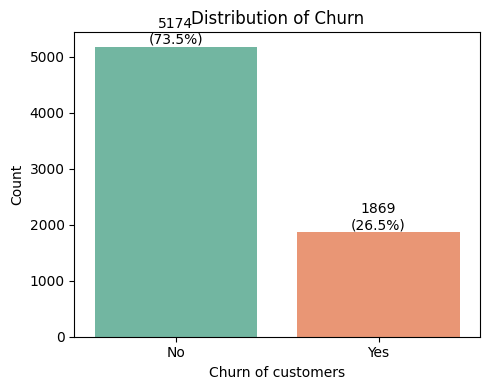

In [36]:

plt.figure(figsize=(5, 4))
ax = sns.countplot(x='Churn', data=df1, palette='Set2')
plt.title("Distribution of Churn")
plt.xlabel("Churn of customers")
plt.ylabel("Count")
plt.xticks([0, 1], ['No', 'Yes'])

# Calcular proporciones
total = len(df1)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total
    ax.annotate(f'{count}\n({percent:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

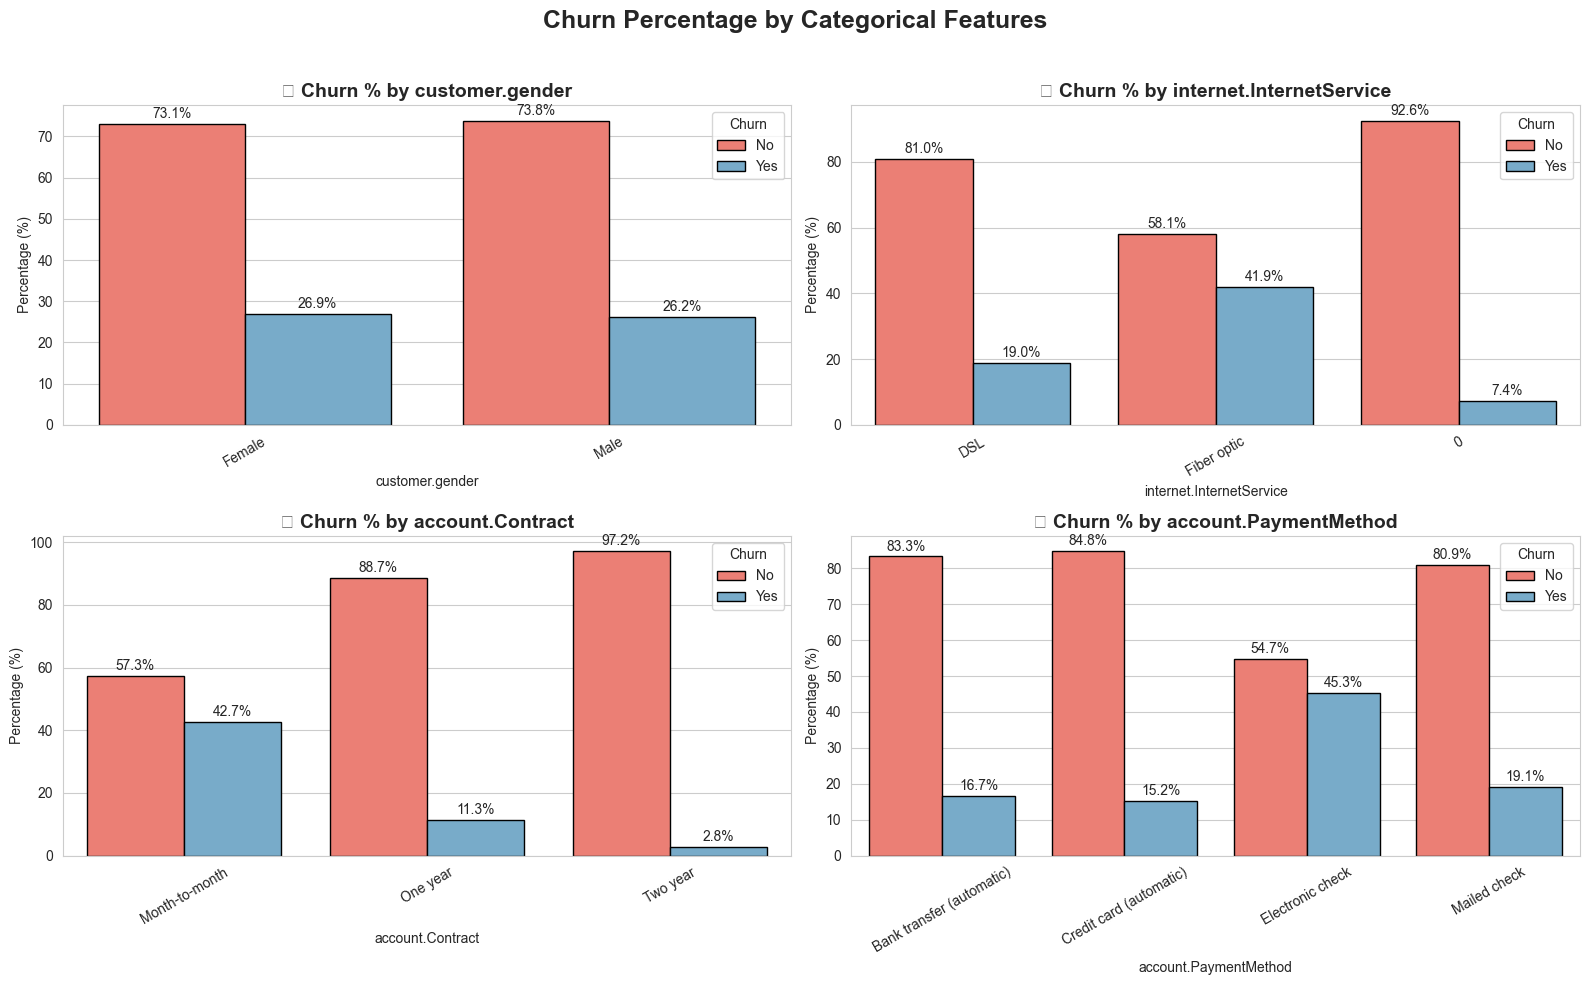

In [37]:
sns.set_style("whitegrid")
custom_palette = ['#FF6F61', '#6BAED6']  # Churn = Yes, No

cat_features = [
    'customer.gender',
    'internet.InternetService',
    'account.Contract',
    'account.PaymentMethod'
]

n = len(cat_features)
rows = (n + 1) // 2

fig, axes = plt.subplots(rows, 2, figsize=(16, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(cat_features):
    temp_df = df1.copy()
    temp_df['Churn'] = temp_df['Churn'].map({True: 'Yes', False: 'No'})
    
    grouped = temp_df.groupby([feature, 'Churn']).size().reset_index(name='count')
    grouped['total'] = grouped.groupby(feature)['count'].transform('sum')
    grouped['Percentage'] = 100 * grouped['count'] / grouped['total']
    
    sns.barplot(
        data=grouped,
        x=feature,
        y='Percentage',
        hue='Churn',
        palette=custom_palette,
        ax=axes[i],
        edgecolor='black'
    )
    
    axes[i].set_title(f'📊 Churn % by {feature}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Percentage (%)')
    axes[i].set_xlabel(feature)
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].legend(title='Churn', loc='upper right')
    
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.1f%%', padding=2, fontsize=10)

# Ocultar ejes vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Churn Percentage by Categorical Features', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


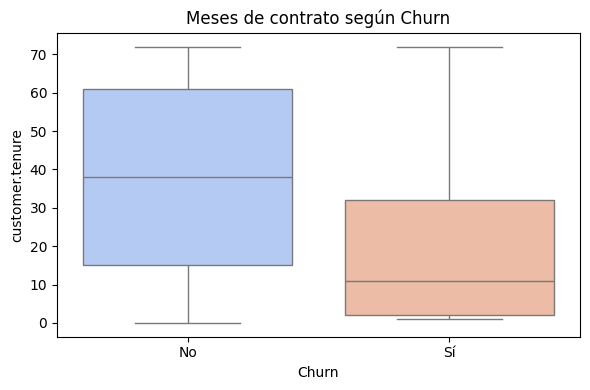

In [ ]:

plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='customer.tenure', data=df1, palette='coolwarm')
plt.title("Months according to the Churn contract")
plt.xticks([0, 1], ['No', 'Sí'])
plt.tight_layout()
plt.show()

- Churned customers show much lower tenure than those who stayed.
- This indicates that the first few months are critical for customer retention.

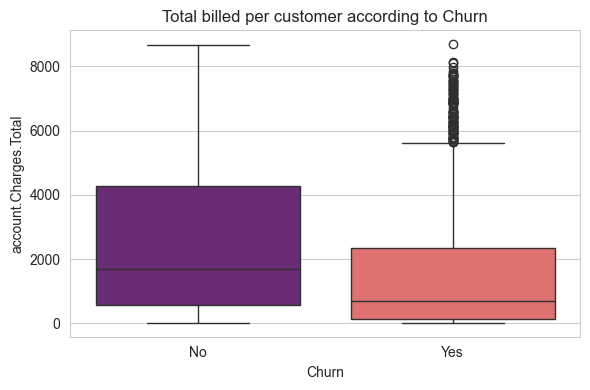

In [ ]:

plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='account.Charges.Total', data=df1, palette='magma')
plt.title("Total billed per customer according to Churn")
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

- Customers who did not churn accumulated significantly higher total charges.
- This reflects their longer relationship with the company and higher overall customer value.
- There is so much data outlayers when the customer churned that is mean that the churned customers paid a lot of money.

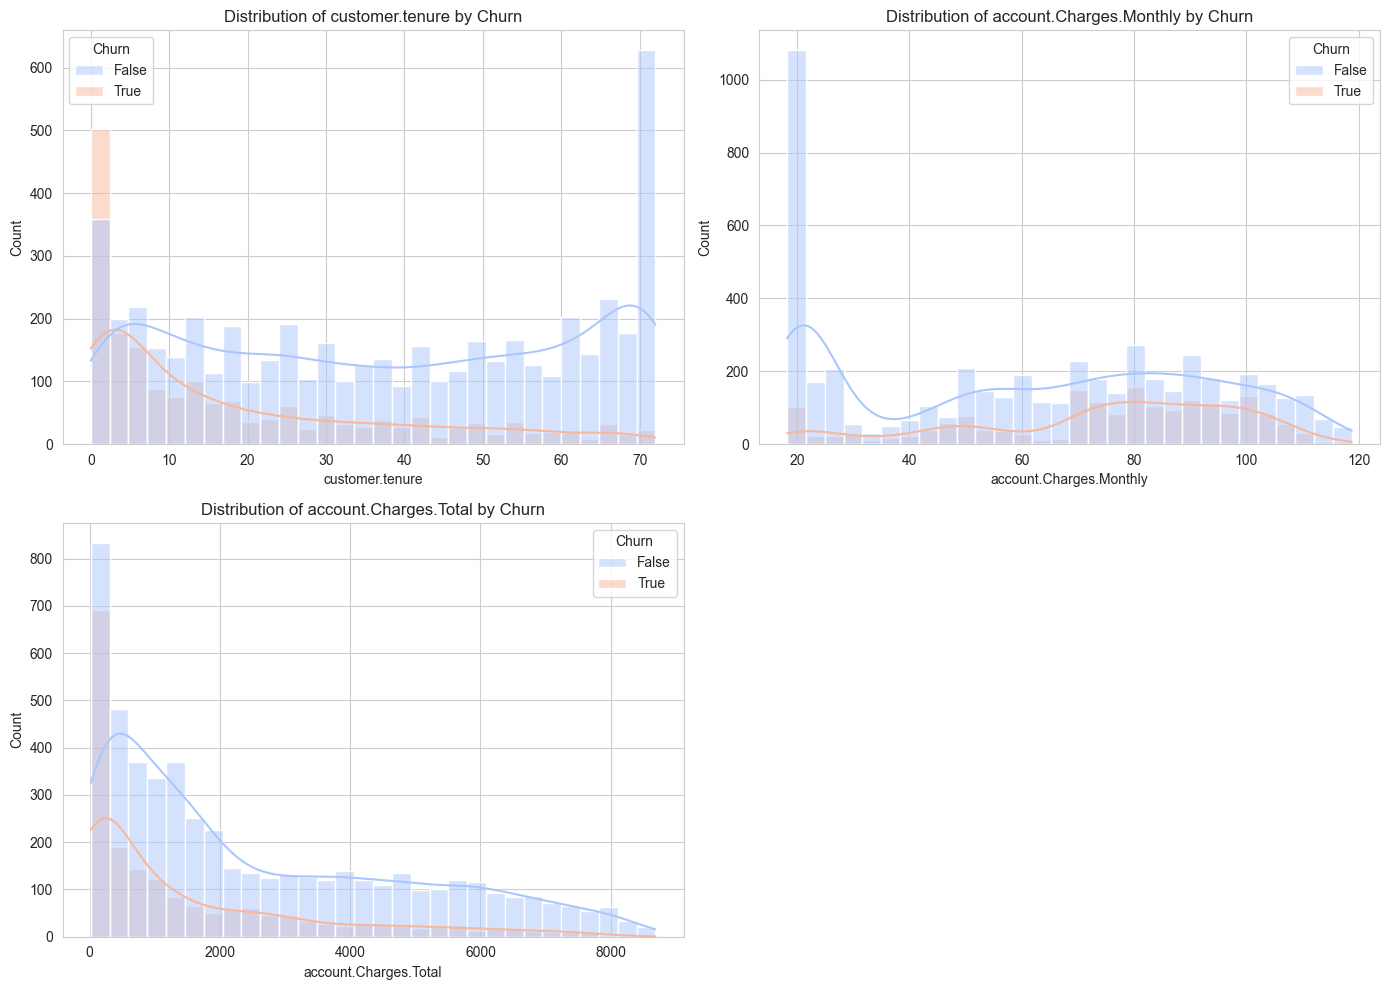

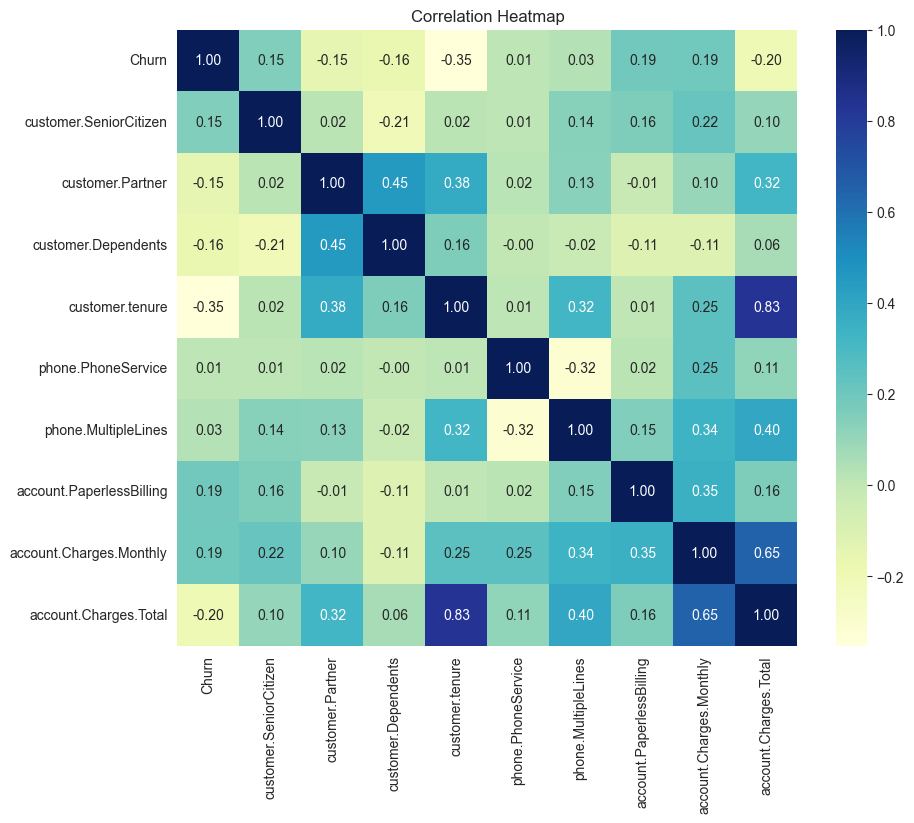

In [42]:
# --- 5. Churn by Numerical Features ---
numeric_features = ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))  # 2 rows, 2 columns
axes = axes.flatten()  

for i, feature in enumerate(numeric_features):
    sns.histplot(data=df1, x=feature, hue='Churn', kde=True, palette='coolwarm', bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature} by Churn")


if len(numeric_features) < len(axes):
    for j in range(len(numeric_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# --- 6. Correlation Analysis ---
plt.figure(figsize=(10, 8))
corr = df1.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

#📄 Final Report

## 📘 Final Report — Exploratory Analysis of Customer Churn at TelecomX LATAM

---

### 🔹 Introduction

Customer churn represents one of the most significant threats to service-based companies, especially in the telecommunications sector. Retaining an existing customer is often more profitable than acquiring a new one, which makes churn analysis a priority for business profitability and sustainability.

In this project, we performed an analysis of customer data from **TelecomX LATAM** with the goal of identifying patterns, behaviors, and characteristics associated with service cancellation.

---

### 🔹 Data Cleaning and Preprocessing

The first step was data cleaning, as a fundamental part of the preprocessing phase:

- **Dataset Import:** Loaded the file containing customer information, contracted services, and churn status.
- **Initial Exploration:** Reviewed the structure of the DataFrame, column names, variable types, and general statistical summary.
- **Handling Missing and Anomalous Values:**  
  - Missing values were imputed or removed depending on the importance of each variable.
  - Inconsistent records were reviewed (e.g., customers with 0 tenure but active services).
- **Data Type Conversion:** Ensured appropriate formats (dates, integers, booleans, strings).
- **Categorical Variable Transformation:** Applied encoding when needed for later modeling steps (label encoding or one-hot encoding).

---

### 🔹 Exploratory Data Analysis (EDA)

The exploratory analysis focused on understanding how different variables influence the probability of churn and general behavior at TelecomX.

### ✅ Key Findings:

#### 1. **Churn Distribution**

- Approximately **26.5%** of customers have churned.
- This reflects a **relevant retention issue**, although not an extreme one.

#### 2. **Contract Type**

- Customers with **monthly contracts** show significantly higher churn rates than those with yearly or biannual contracts.
- The flexibility of monthly plans seems to result in **lower customer loyalty**.

#### 3. **Payment Method**

- Customers using **automatic electronic payments** showed higher churn rates compared to other payment methods.
- This may be related to the **user experience or perceived control** over payments.

#### 4. **Subscribed Services**

- Customers who **do not subscribe to Internet or TV services** are more likely to churn.
- The **more services** a customer subscribes to, the **less likely** they are to leave.

#### 5. **Customer Tenure**

- Customers with **less than 6 months** of tenure show higher churn rates.
- This indicates a **potential failure in the onboarding or early engagement process**.

#### 6. **Segmentation by Gender, Service Type, and Technical Characteristics**

- Variables such as service type (fiber optic vs DSL) were related to churn.
- No significant differences were found based on gender.

---

### 🔹 Conclusions and Insights

From the analysis, the following critical points emerged:

1. **Short and flexible contracts** → high churn vulnerability.  
2. **New customers** → more likely to leave if they don't receive early value.  
3. **Basic services without bundling** → less customer retention.  
4. **Fully automated electronic payments** → may require user experience improvements.  
5. **High monthly charges without clear justification** → may drive dissatisfaction and churn.

#### 🧠 Correlation Matrix Highlights:

- **`tenure` and `TotalCharges`** show a **strong positive correlation**, as expected—longer tenure results in higher total charges.
- **`MonthlyCharges`** is **moderately correlated** with `TotalCharges` but **not with `tenure`**, suggesting that monthly fees vary widely regardless of how long the customer has stayed.
- **`Churn`** shows **negative correlations** with both `tenure` and `TotalCharges`, indicating:
  - Customers with **low tenure** are more likely to churn.
  - Customers who have **paid more over time** are more likely to stay.
- `MonthlyCharges` is **slightly positively correlated** with `Churn`, suggesting that **customers with higher monthly bills** may be more prone to churn.

---

### 🔹 Strategic Recommendations

Based on the findings, the following actions are proposed:

#### 1. **Redesign Short-Term Contracts**

- Encourage migration to yearly contracts through discounts, bonus features, or free services.

#### 2. **Strengthen the Onboarding Process**

- Implement welcome campaigns and personalized follow-ups during the first 60 days.

#### 3. **Offer Bundled Services**

- Promote packages (Internet + TV + Phone) with added benefits to increase customer retention.

#### 4. **Improve the Payment Experience**

- Enhance clarity and usability of the electronic payment system.
- Add notifications, detailed invoices, and more flexible options.

---

